# Forest Cover Type Prediction

Name \hfill Data Type / Measurement / Description 

Elevation / quantitative /meters / Elevation in meters 
Aspect / quantitative / azimuth / Aspect in degrees azimuth 
Slope / quantitative / degrees / Slope in degrees 
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features 
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

## Traitement des données

### Télécharement des données

In [1]:
from urllib.request import urlopen
import os.path as osp
import os
import logging
import gzip
logging.getLogger().setLevel('INFO')

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')
    output.write(url.read())
    output.close()
    
BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
DATA_DIR = 'covtype'

DATA_URL = BASE_URL + DATA_DIR + "/covtype.data.gz"

os.makedirs(osp.join(DATA_DIR, 'archives'), exist_ok=True)

logging.info("downloading & extracting file %s", DATA_URL)
archive_path = osp.join(DATA_DIR, 'archives', osp.basename(DATA_URL))
download_file(DATA_URL, archive_path)

INFO:root:downloading & extracting file https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz


### Visualisation des données

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from display import display_classifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
features_names = {'Elevation':[0],'Aspect':[1],'Slope':[2],
                  'Horizontal_Distance_To_Hydrology':[3],
                  'Vertical_Distance_To_Hydrology':[4],
                  'Horizontal_Distance_To_Roadways':[5],
                  'Hillshade_9am':[6],'Hillshade_Noon':[7],
                  'Hillshade_3pm':[8],
                  'Horiontal_Distance_To_Fire_Points':[9],
                  'Wilderness_Area':[10,11,12,13],
                  'Soil_Type':list(range(14,54)),
                  'Cover_Type':[54]}

def convert_to_listofint(df_attribut):
    return [[int(x) for x in X.split()] for X in df_attribut]

def convert_to_int(df_attribut):
    return [int(x) for x in df_attribut]

df_covtype = pd.read_csv('covtype/archives/covtype.data.gz',
                         header=None,
                         parse_dates=features_names,
                         compression='gzip')

for attribut in features_names:
    if attribut in ['Wilderness_Area','Soil_Type']:
        df_covtype[attribut] = convert_to_listofint(df_covtype[attribut])
    else:
        df_covtype[attribut] = convert_to_int(df_covtype[attribut])

## Analyse préliminaire et pré-traitement des données 

On regarde d'abord les valeurs moyennes de chaque attribut, par classe, pour observer une première fois les 

In [5]:
df_covtype.groupby('Cover_Type').mean()

,Horiontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Hillshade_Noon,Aspect,Vertical_Distance_To_Hydrology,Elevation,Hillshade_3pm,Slope,Hillshade_9am,Horizontal_Distance_To_Roadways
Cover_Type,,,,,,,,,,
1,2009.253517,270.555245,223.430211,156.138227,42.156939,3128.644888,143.875038,13.127110,211.998782,2614.834517
2,2168.154849,279.916442,225.326596,152.060515,45.884219,2920.936061,142.983466,13.550499,213.844423,2429.530799
3,910.955949,210.276473,215.826537,176.372490,62.446915,2394.509845,140.367176,20.770208,201.918415,943.940734
4,859.124135,106.934838,216.997088,137.139425,41.186749,2223.939934,111.392792,18.528941,228.345832,914.199490
5,1577.719794,212.354893,219.035816,139.283051,50.610344,2787.417571,121.920889,16.641315,223.474876,1349.765722
6,1055.351471,159.853458,209.827662,180.539068,45.437439,2419.181897,148.284044,19.048886,192.844302,1037.169805
7,2070.031594,356.994686,221.746026,153.236226,69.474305,3361.928669,134.932033,14.255924,216.967723,2738.250463


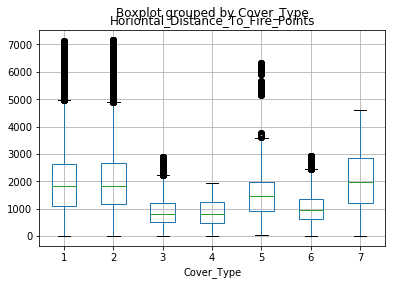

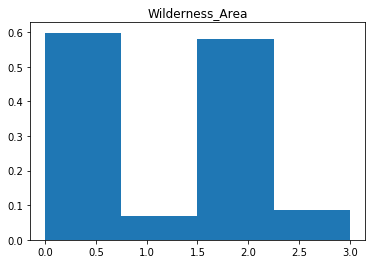

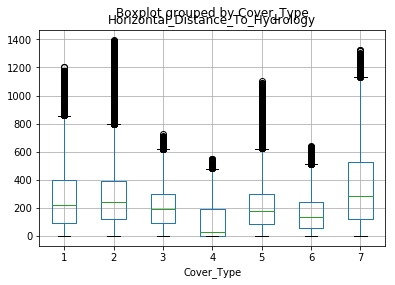

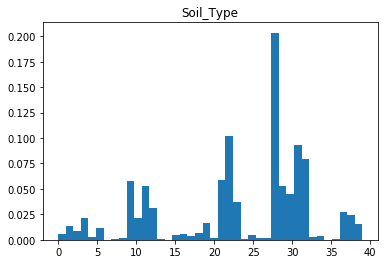

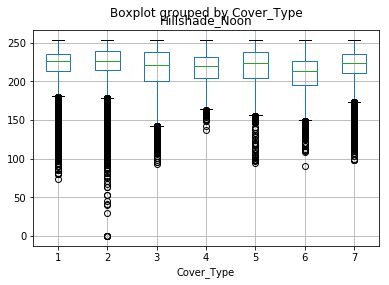

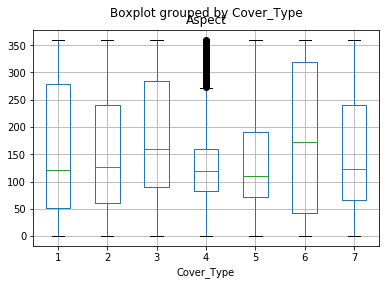

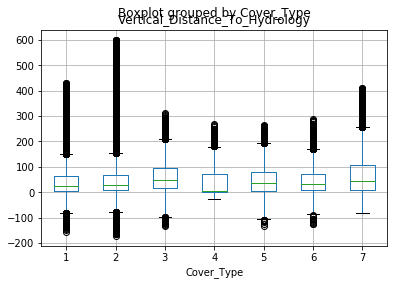

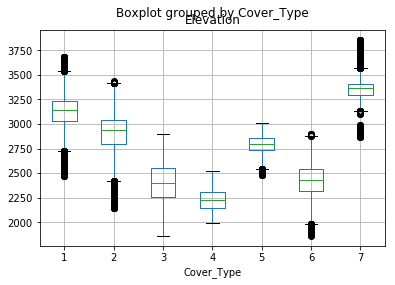

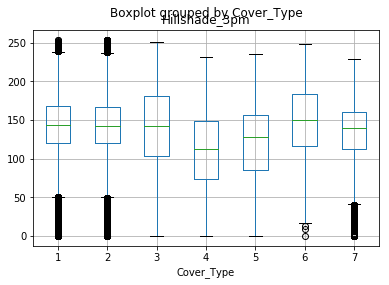

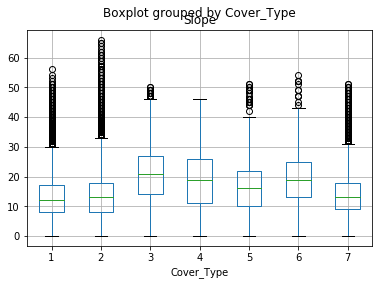

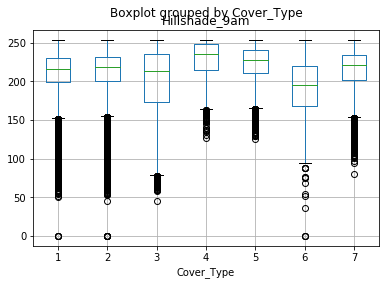

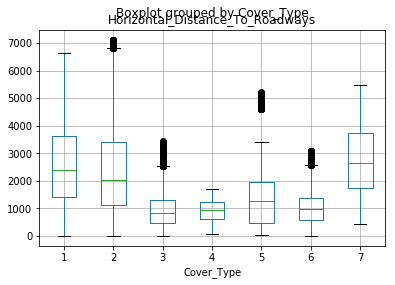

In [6]:
for attribut in features_names:
    if attribut in ['Wilderness_Area','Soil_Type']:
        histogram = [x.index(1) for x in df_covtype[attribut]]
        plt.hist(histogram,density=True,
                 bins=len(df_covtype[attribut][0]))
        plt.title(attribut)
        plt.show()
    elif not(attribut is 'Cover_Type'):
        df_covtype.boxplot(column=attribut,by='Cover_Type')
        df_covtype[attribut] /= max(df_covtype[attribut]) # On profite de la boucle pour normaliser les colonnes
        plt.show()

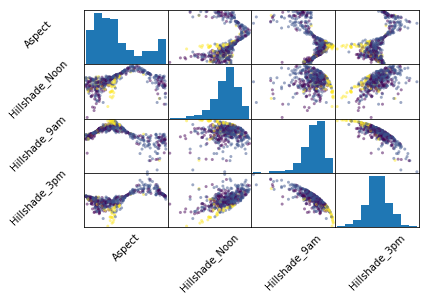

In [7]:
def scatter(keys):
    sm = scatter_matrix(df_covtype[keys][:500],
                   c=df_covtype.Cover_Type.values[:500])

    #Change label rotation
    [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
    [s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

    #May need to offset label when rotating to prevent overlap of figure
    [s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]

    #Hide all ticks
    [s.set_xticks(()) for s in sm.reshape(-1)]
    [s.set_yticks(()) for s in sm.reshape(-1)]
    plt.show()
    
scatter(['Aspect','Hillshade_Noon','Hillshade_9am','Hillshade_3pm'])

On peut voir que les données sont corrélées. On peut potentiellement réduire le nombre d'attributs.

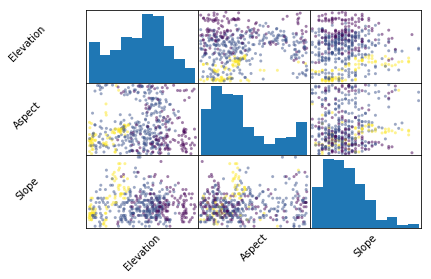

In [8]:
scatter(['Elevation','Aspect','Slope'])

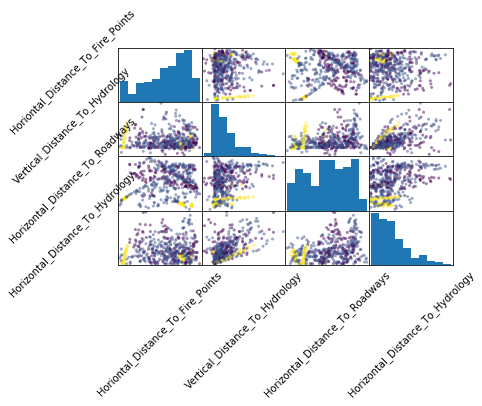

In [9]:
scatter(['Horiontal_Distance_To_Fire_Points',
        'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways',
        'Horizontal_Distance_To_Hydrology'])

### Données de train/validation/test

In [10]:
data = df_covtype.drop(['Cover_Type','Wilderness_Area','Soil_Type'],axis=1).values
target = df_covtype.Cover_Type.values

# Ensemble de train et ensemble de test
(x_train,x_test,y_train,y_test) = train_test_split(data,target,
                                                  random_state=0,
                                                  test_size=.1)

# Ensemble de validation 
(x_train,x_valid,y_train,y_valid) = train_test_split(x_train,
                                                     y_train,
                                                     test_size=.11)

print("x_train shape:", x_train.shape, 
      "y_train shape:", y_train.shape)
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (465389, 10) y_train shape: (465389,)
465389 train set
57521 validation set
58102 test set


## Test de différents modèles

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors","Decision Tree",
         "Random Forest", "Neural Net"]

classifiers = [
    KNeighborsClassifier(10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(hidden_layer_sizes=10,alpha=20)]

/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
for name, clf in zip(names, classifiers):
    clf.fit(x_train,y_train)
    predicted = clf.predict(x_valid)
    
    print('--------------------\n',name,'\n--------------------')
    print('Matrice de confusion :\n',confusion_matrix(y_valid,predicted),'\n')
    print(classification_report(y_valid,predicted))

    # Evaluate the model on test set
    score = clf.score(x_test, y_test)

    # Print test accuracy
    print('\n', 'Test accuracy:', score)

--------------------
 Nearest Neighbors 
--------------------
Matrice de confusion :
 [[19031  1807     4     0    17     3    78]
 [ 2318 25388   136     0    81    88    19]
 [   10   292  3123    21     4   174     0]
 [    0     5    66   173     0    29     0]
 [   43   300    11     0   568     2     0]
 [    7   257   291    13     8  1153     0]
 [  306    44     0     0     0     0  1651]] 

             precision    recall  f1-score   support

          1       0.88      0.91      0.89     20940
          2       0.90      0.91      0.90     28030
          3       0.86      0.86      0.86      3624
          4       0.84      0.63      0.72       273
          5       0.84      0.61      0.71       924
          6       0.80      0.67      0.73      1729
          7       0.94      0.83      0.88      2001

avg / total       0.89      0.89      0.89     57521


 Test accuracy: 0.8892981308732918
--------------------
 Decision Tree 
--------------------
Matrice de confusion :

/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------
 Random Forest 
--------------------
Matrice de confusion :
 [[ 6800 14139     1     0     0     0     0]
 [ 2106 25895    29     0     0     0     0]
 [    1  2681   942     0     0     0     0]
 [    0   237    36     0     0     0     0]
 [   13   911     0     0     0     0     0]
 [    2  1436   291     0     0     0     0]
 [  750  1251     0     0     0     0     0]] 

             precision    recall  f1-score   support

          1       0.70      0.32      0.44     20940
          2       0.56      0.92      0.69     28030
          3       0.73      0.26      0.38      3624
          4       0.00      0.00      0.00       273
          5       0.00      0.00      0.00       924
          6       0.00      0.00      0.00      1729
          7       0.00      0.00      0.00      2001

avg / total       0.57      0.58      0.52     57521



/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 Test accuracy: 0.5859178685759526
--------------------
 Neural Net 
--------------------
Matrice de confusion :
 [[    0 20940     0     0     0     0     0]
 [    0 28030     0     0     0     0     0]
 [    0  3624     0     0     0     0     0]
 [    0   273     0     0     0     0     0]
 [    0   924     0     0     0     0     0]
 [    0  1729     0     0     0     0     0]
 [    0  2001     0     0     0     0     0]] 

             precision    recall  f1-score   support

          1       0.00      0.00      0.00     20940
          2       0.49      1.00      0.66     28030
          3       0.00      0.00      0.00      3624
          4       0.00      0.00      0.00       273
          5       0.00      0.00      0.00       924
          6       0.00      0.00      0.00      1729
          7       0.00      0.00      0.00      2001

avg / total       0.24      0.49      0.32     57521


 Test accuracy: 0.48950122198891605


Au premier regard, on peut se dire que la methode des k-plus proches voisins est la plus adaptée. On teste donc plusieurs hyperparamètres.

In [13]:
error = []
K = range(1,5)

for k in K:
    clf = KNeighborsClassifier(k)
    clf.fit(x_train,y_train)
    predicted = clf.predict(x_valid)
    
    print('\n-----------------------------\n' 
          + "Nearest Neighbors : "
          + "k = " + str(k)
          + '\n-----------------------------\n')
    print('Matrice de confusion :\n',confusion_matrix(y_test,predicted),'\n')
    print(classification_report(y_valid,predicted))

    # Evaluate the model on test set
    score = clf.score(x_valid, y_valid)

    # Print test accuracy
    print('\n', 'Test accuracy:', score)


-----------------------------
Nearest Neighbors : k = 1
-----------------------------



ValueError: Found input variables with inconsistent numbers of samples: [58102, 57521]

### Multi-layer perceptron

In [ ]:
clf = MLPClassifier(alpha=.01,activation='relu')
clf.fit(x_train,y_train)
predicted = clf.predict(x_valid)
    
print('-----------------------\n',name,'\n-----------------------')
print('Matrice de confusion :\n',confusion_matrix(y_valid,predicted),'\n')
print(classification_report(y_valid,predicted))

# Evaluate the model on test set
score = clf.score(x_valid, y_valid)

# Print test accuracy
print('\n', 'Test accuracy:', score)